In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve, validation_curve
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

### Data Preparation

In [185]:
# Load the dataset
CPS = pd.read_csv("CPS.csv")

In [186]:
# Filter data: Remove individuals aged 17 or below, irrelevant codes in 'UHRSWORKLY', and non-relevant DIFFANY codes
CPS = CPS[(CPS['AGE'] > 17) & (~CPS['UHRSWORKLY'].isin([999, 997])) & (~CPS['DIFFANY'].isin([0]))]

In [187]:
# Create a binary variable for Child Tax Credit receipt (CTCCRD_dummy)
CPS['CTCCRD_dummy'] = CPS['ACTCCRD'].apply(lambda x: 1 if x > 0 else 0)

In [188]:
# Check the first few rows of the data to ensure cleaning steps were successful
CPS.head()

,YEAR,SERIAL,MONTH,CPSID,ASECFLAG,ASECWTH,PERNUM,CPSIDV,CPSIDP,ASECWT,...,UHRSWORKLY,WKSUNEM1,CTCCRD,ACTCCRD,EITCRED,DISABWRK,HEALTH,GOTWIC,KIDCNEED,CTCCRD_dummy
0,2022,1,3,20210102744400,1,2553.13,1,202101027444011,20210102744401,2553.13,...,40,99,0,0,0,1,3,0,0,0
1,2022,5,3,20211202723000,1,1586.80,1,202112027230011,20211202723001,1586.80,...,32,0,0,0,0,1,3,0,0,0
2,2022,5,3,20211202723000,1,1586.80,2,202112027230021,20211202723002,1586.80,...,40,99,0,0,0,1,2,0,0,0
3,2022,6,3,20220202720300,1,1492.59,1,202202027203011,20220202720301,1492.59,...,48,99,0,0,0,1,1,0,0,0
4,2022,6,3,20220202720300,1,1492.59,2,202202027203021,20220202720302,1492.59,...,40,0,0,0,0,2,5,1,0,0


In [189]:
# Summary statistics of key variables
print(CPS[['UHRSWORKLY', 'ACTCCRD', 'AGE', 'EITCRED', 'HEALTH']].describe())

         UHRSWORKLY       ACTCCRD           AGE       EITCRED        HEALTH
count  73713.000000  73713.000000  73713.000000  73713.000000  73713.000000
mean      39.119355   1192.798760     43.107308    271.127400      2.145361
std       10.993700   2663.294732     14.329529    912.707167      0.932534
min        1.000000      0.000000     18.000000      0.000000      1.000000
25%       40.000000      0.000000     32.000000      0.000000      1.000000
50%       40.000000      0.000000     42.000000      0.000000      2.000000
75%       40.000000      0.000000     54.000000      0.000000      3.000000
max       99.000000  37800.000000     85.000000   6728.000000      5.000000


In [190]:
# Function to calculate and print skewness and kurtosis for key variables
def calc_skew_kurt(data, var):
    skew = data[var].skew()
    kurtosis = data[var].kurt()
    print(f"Skewness of {var}: {skew}")
    print(f"Kurtosis of {var}: {kurtosis}")

In [191]:
# Calculate skewness and kurtosis for key variables
for var in ['UHRSWORKLY', 'ACTCCRD', 'AGE', 'EITCRED', 'HEALTH']:
    calc_skew_kurt(CPS, var)

Skewness of UHRSWORKLY: -0.14881099219451724
Kurtosis of UHRSWORKLY: 3.497443875857971
Skewness of ACTCCRD: 2.7511027368325642
Kurtosis of ACTCCRD: 9.501360161344389
Skewness of AGE: 0.2480399331751674
Kurtosis of AGE: -0.7020209214217252
Skewness of EITCRED: 4.410884886998276
Kurtosis of EITCRED: 21.095376778572465
Skewness of HEALTH: 0.4643569783217292
Kurtosis of HEALTH: -0.30866470167065163


In [192]:
# Frequency table of CTCCRD_dummy
ctc_freq_table = CPS['CTCCRD_dummy'].value_counts(normalize=True) * 100
ctc_count_table = CPS['CTCCRD_dummy'].value_counts()
ctc_summary = pd.DataFrame({'Count': ctc_count_table, 'Percentage': ctc_freq_table})
print(ctc_summary)

              Count  Percentage
CTCCRD_dummy                   
0             57405   77.876358
1             16308   22.123642


In [193]:
# Frequency table of DIFFANY
diffany_freq_table = CPS['DIFFANY'].value_counts(normalize=True) * 100
diffany_count_table = CPS['DIFFANY'].value_counts()
diffany_summary = pd.DataFrame({'Count': diffany_count_table, 'Percentage': diffany_freq_table})
print(diffany_summary)

         Count  Percentage
DIFFANY                   
1        70088   95.082279
2         3625    4.917721


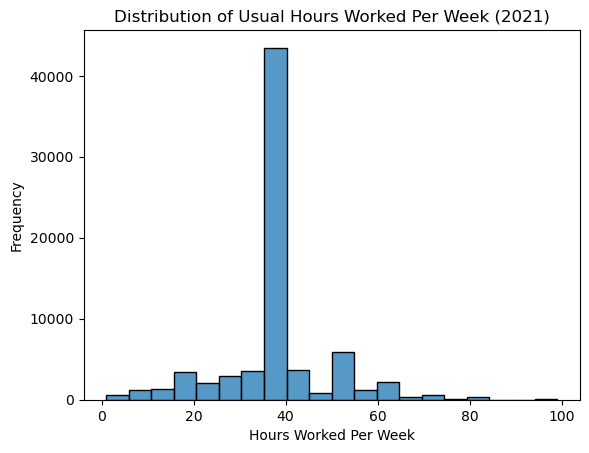

In [194]:
# Plot: Distribution of Usual Hours Worked per Week (excluding outliers > 100)
sns.histplot(CPS['UHRSWORKLY'][CPS['UHRSWORKLY'] <= 100], bins=20)
plt.title("Distribution of Usual Hours Worked Per Week (2021)")
plt.xlabel("Hours Worked Per Week")
plt.ylabel("Frequency")
plt.show()

In [195]:
# Binning 'UHRSWORKLY' variable into categories
bins = [0, 40, 80, 100]
labels = ['0-40', '41-80', '81-100']
CPS['UHRSWORKLY_binned'] = pd.cut(CPS['UHRSWORKLY'], bins=bins, labels=labels, right=False)

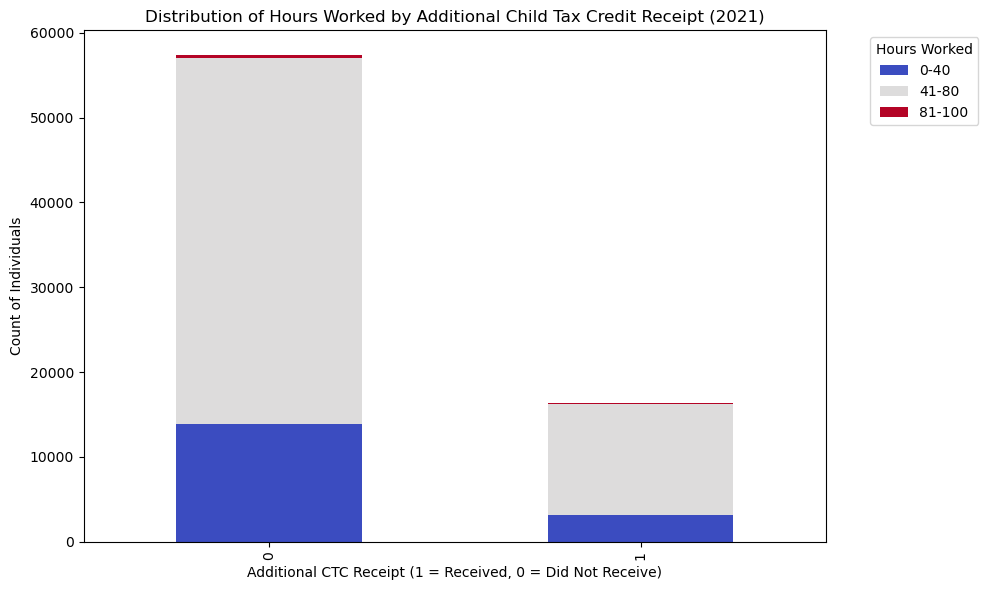

In [196]:
# Grouped data: Distribution of Hours Worked by Child Tax Credit Receipt
grouped_data = CPS.groupby(['CTCCRD_dummy', 'UHRSWORKLY_binned'], observed=False).size().unstack(fill_value=0)
ax = grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='coolwarm')
plt.title("Distribution of Hours Worked by Additional Child Tax Credit Receipt (2021)")
plt.xlabel("Additional CTC Receipt (1 = Received, 0 = Did Not Receive)")
plt.ylabel("Count of Individuals")
plt.legend(title="Hours Worked", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

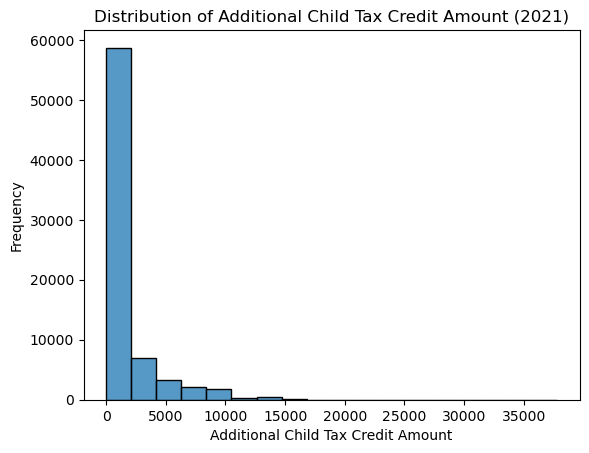

In [197]:
# Plot: Distribution of Additional Child Tax Credit Amount
sns.histplot(CPS['ACTCCRD'])
plt.title("Distribution of Additional Child Tax Credit Amount (2021)")
plt.xlabel("Additional Child Tax Credit Amount")
plt.ylabel("Frequency")
plt.show()

### Analysis #1: Parametric Technique (Linear Regression)

In [199]:
# Prepare feature matrix (X) and target variable (y)
X = CPS[['ACTCCRD', 'CTCCRD_dummy', 'EITCRED', 'AGE', 'HEALTH', 'DIFFANY']] 
y = CPS['UHRSWORKLY']

In [200]:
# Split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)
print(f'X train shape: {Xtrain.shape}, y train shape: {ytrain.shape}')

X train shape: (55284, 6), y train shape: (55284,)


In [201]:
# Initialize and fit the Linear Regression model
model = LinearRegression(fit_intercept=True)
model.fit(Xtrain, ytrain)

LinearRegression()

In [202]:
# Coefficients for each feature
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

              Coefficient
ACTCCRD          0.000026
CTCCRD_dummy     2.408579
EITCRED         -0.001694
AGE              0.036138
HEALTH          -0.270331
DIFFANY         -2.687206


In [203]:
# Evaluate model performance on training and test data (R² score)
train_score = model.score(Xtrain, ytrain)
test_score = model.score(Xtest, ytest)
print(f'Training data R² score: {train_score:.4f}')
print(f'Test data R² score: {test_score:.4f}')

Training data R² score: 0.0257
Test data R² score: 0.0248


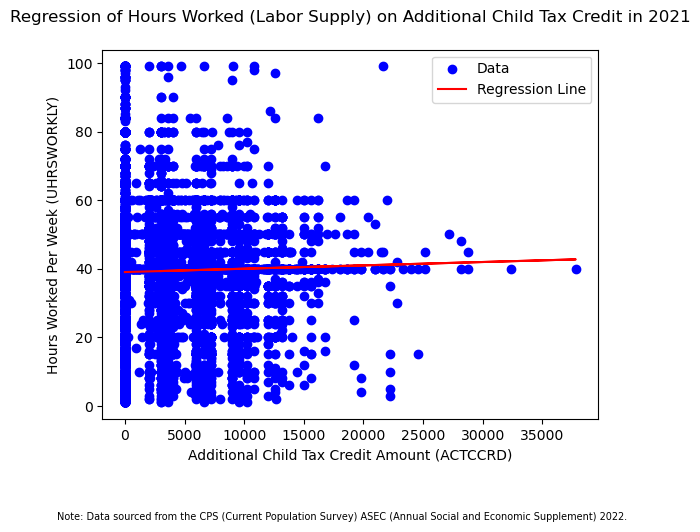

In [204]:
# Visualize Linear Regression model: Plot 'ACTCCRD' vs. 'UHRSWORKLY'
model.fit(Xtrain[['ACTCCRD']], ytrain)
plt.scatter(Xtrain['ACTCCRD'], ytrain, color='blue', label='Data')
plt.plot(Xtrain['ACTCCRD'], model.predict(Xtrain[['ACTCCRD']]), color='red', label='Regression Line')
plt.xlabel("Additional Child Tax Credit Amount (ACTCCRD)")
plt.ylabel("Hours Worked Per Week (UHRSWORKLY)")
plt.title("Regression of Hours Worked (Labor Supply) on Additional Child Tax Credit in 2021", pad=20)
plt.legend()
plt.figtext(0.5, -0.1, "Note: Data sourced from the CPS (Current Population Survey) ASEC (Annual Social and Economic Supplement) 2022.", 
            ha="center", fontsize=7)
plt.show()

### Analysis #2: Non-Parametric Technique (Decision Tree Classifier)

In [206]:
# Binning 'UHRSWORKLY' variable into categories
bins = [0, 40, 80, 100]  
labels = ['0-40', '41-80', '81-100']

# Create a new column for binned hours worked
CPS['UHRSWORKLY_binned'] = pd.cut(CPS['UHRSWORKLY'], bins=bins, labels=labels, right=False)

# Check the distribution of binned hours worked
print(CPS['UHRSWORKLY_binned'].value_counts())

UHRSWORKLY_binned
41-80     56153
0-40      17127
81-100      433
Name: count, dtype: int64


In [207]:
# Prepare feature matrix (X) and target variable (y)
X = CPS[['ACTCCRD', 'CTCCRD_dummy', 'EITCRED', 'AGE', 'HEALTH', 'DIFFANY']]  
y = CPS['UHRSWORKLY_binned']  # Use the binned version of UHRSWORKLY

In [208]:
# Split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [209]:
# Decision Tree with a maximum depth of 5
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(Xtrain, ytrain)

DecisionTreeClassifier(max_depth=5)

In [210]:
# Evaluate model performance on training and test data 
train_score = tree.score(Xtrain, ytrain)
test_score = tree.score(Xtest, ytest)

In [211]:
print(f"Training accuracy: {train_score:.4f}")
print(f"Test accuracy: {test_score:.4f}")

Training accuracy: 0.7828
Test accuracy: 0.7805


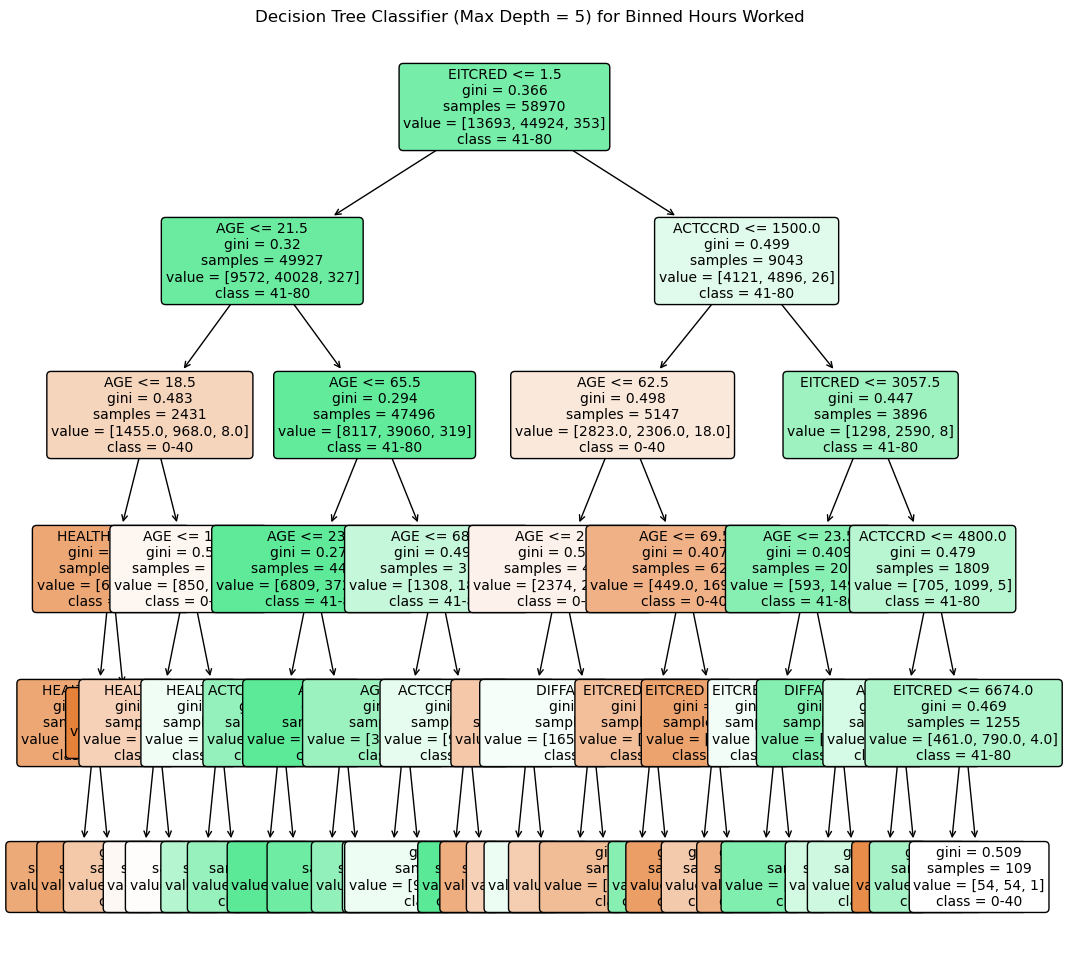

In [212]:
# Plot the decision tree
plt.figure(figsize=(12, 12))
plot_tree(tree, filled=True, feature_names=Xtrain.columns, class_names=labels, rounded=True, fontsize=10)
plt.title("Decision Tree Classifier (Max Depth = 5) for Binned Hours Worked")
plt.show()

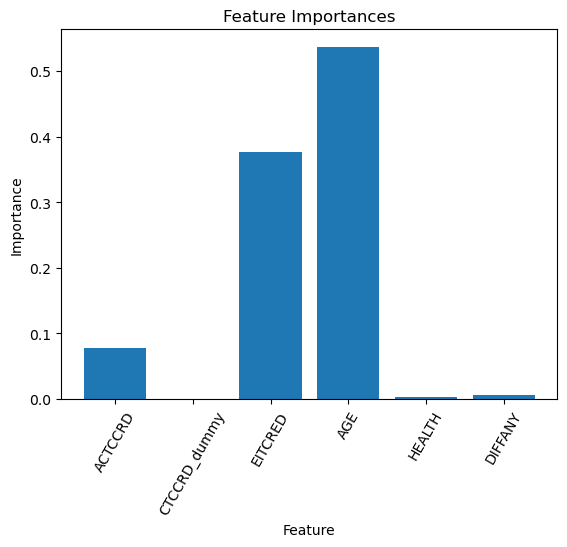

In [213]:
# Feature Importances from Decision Tree
plt.bar(Xtrain.columns, tree.feature_importances_)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=60)
plt.show()

#### Cross-validation for Decision Tree Classifier

In [215]:
cv_scores = cross_val_score(DecisionTreeClassifier(), X, y, cv=5)
print(f"Cross-validation scores: {cv_scores}")

Cross-validation scores: [0.76931425 0.77623279 0.76239571 0.76794193 0.76651743]


#### Diagnostic Curves: Validation Curves for Decision Tree Classifier

In [217]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [218]:
# Set the range of max_depth values to test
param_range = np.arange(1, 20)

In [219]:
# Generate validation curve data
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(), X, y,
    param_name="max_depth", param_range=param_range,
    cv=cv, n_jobs=-1
)

In [220]:
# Calculate mean and standard deviation for train and test scores
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

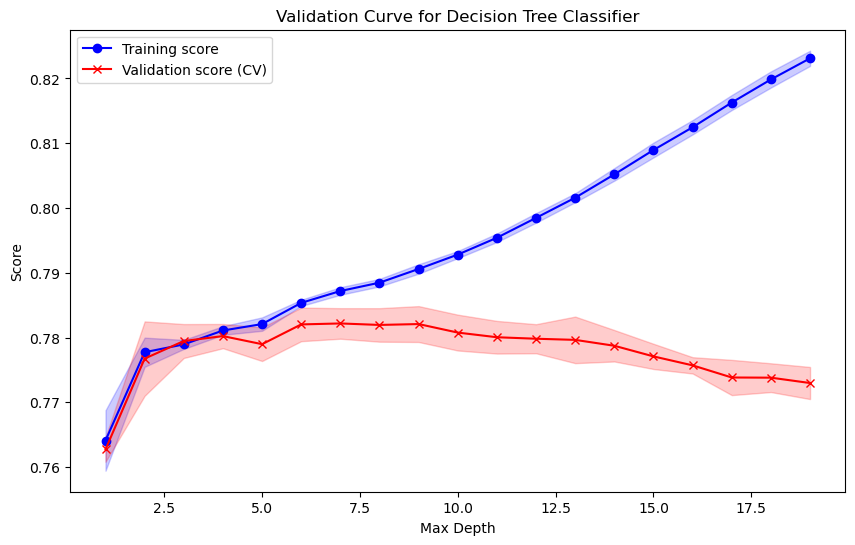

In [221]:
# Plot validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label='Training score', color='blue', linestyle='-', marker='o')
plt.plot(param_range, test_mean, label='Validation score (CV)', color='red', linestyle='-', marker='x')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color='red', alpha=0.2)
plt.title('Validation Curve for Decision Tree Classifier')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.legend()
plt.show()

#### Diagnostic Curves: Learning Curve for Decision Tree Classifier

In [223]:
# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    DecisionTreeClassifier(), X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

In [224]:
# Calculate mean and standard deviation for train and test scores
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

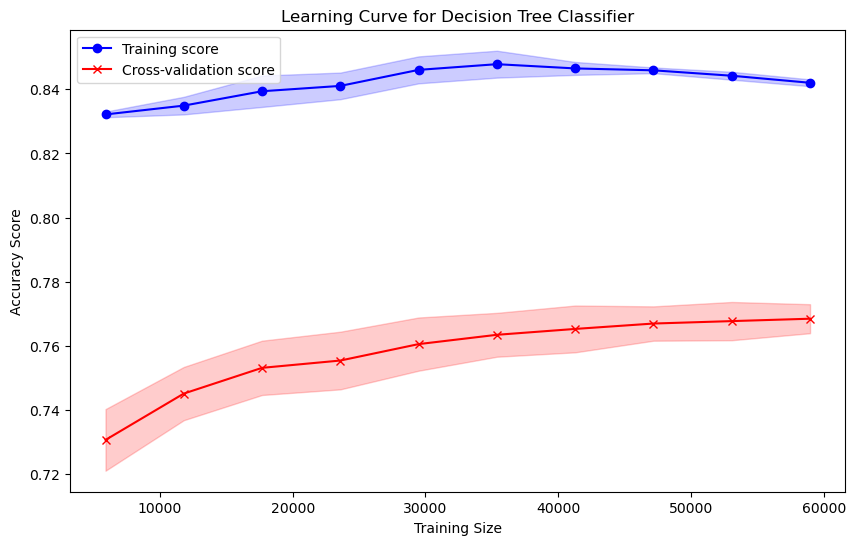

In [225]:
# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue', linestyle='-', marker='o')
plt.plot(train_sizes, test_mean, label='Cross-validation score', color='red', linestyle='-', marker='x')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.2)
plt.title('Learning Curve for Decision Tree Classifier')
plt.xlabel('Training Size')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()